# Functions

In [1]:
import os 
import subprocess

def setup_data_vars(mine = True, overwrite = True):
    """
    From within any directory related to radiotherapy with backtrack into the data folder
    and execute the data_vars script. The assumption is that the datavars script will
    output the list of environment variables that need to be set. This function will set
    the environment variables for the current session.

    For the mean while, my model hasn't completely finished training, therefore, to get
    this task done, I will use Ben's pretrained nnUNet and then once mine has finished
    training I will use my own. For the mean while, this means that we can choose between
    using Ben's pretrained model or my own.
    """

    # If the environment variables are not set, assume that either a custom one has been
    # provided or resetting them again is a redundant task
    if os.environ.get('nnUNet_raw') is None or overwrite is True:
        # run the script in the data folder for specifying the environment variables
        if mine:
            cwd = os.getcwd().split('/')
            data_dir = os.path.join('/'.join(cwd[:cwd.index('radiotherapy') + 1]), 'data')

            # Assuming the data_vars.sh script echoes the environment variables
            script = os.path.join(data_dir, 'data_vars.sh')
            output = subprocess.run([script], capture_output=True)
            
            assert len(output.stdout) != 0, f"Please check {script} and make sure it echoes \
    the environment variables."

            output = output.stdout.decode('utf-8')
        else:
            data_dir = '/vol/biomedic3/bglocker/nnUNet'

            # Assuming this script won't change, it contains hard coded exports
            script = os.path.join(data_dir, 'exports')

            with open(script, 'r') as file:
                output = file.read()
        
        for line in output.split('\n'):
            if line != '':
                if mine:
                    line = line.split(': ')
                    os.environ[line[0]] = line[1]
                else:
                    line = line.split('=')
                    os.environ[line[0].split(' ')[1]] = line[1]

    assert os.environ.get('nnUNet_raw') is not None, "Environemnt variables not set. \
Please run the data_vars.sh script in the data folder."

## Calculate Metrics

In [2]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
import itk
import os
import math

def calculate_metrics(input_path_gt: str, input_path_pred: dict, axis = None):
    """Will return the metrics for each prediction path

    Args:
        input_path_gt (str): a string to the ground truth 
        input_path_pred (dict): a dictionary containing the paths to the predictions
        axis (int, optional): the axis to calculate the metrics on. Defaults to None.

    Returns:
        dict: returns dictionary of metrics for the main prediction paths
    """

    def read_slice(image, slice_index, axis):
        # https://examples.itk.org/src/filtering/imagegrid/processa2dsliceofa3dimage/documentation
        size = image.GetLargestPossibleRegion().GetSize()

        # Create an image region that will be used to extract a single slice along an axis
        extractRegion = image.GetLargestPossibleRegion()

        # Create an extract region set to extract a single slice along an axis
        extractRegion_size = [size[0], size[1], size[2]]
        extractRegion_size[axis] = 1
        extractRegion.SetSize(extractRegion_size)

        # Update extracting region to current slice
        extractRegion_index = [0] * 3
        extractRegion_index[axis] = slice_index
        extractRegion.SetIndex(extractRegion_index)

        # Extract Region
        extractFilter = itk.ExtractImageFilter.New(image)
        extractFilter.SetDirectionCollapseToSubmatrix()
        extractFilter.SetExtractionRegion(extractRegion)

        # Extract Data
        sliceImage = extractFilter.GetOutput()
        sliceImage.Update()
        return itk.array_from_image(sliceImage)


    ground_truth = [os.path.join(input_path_gt, file) for file in sorted(filter(lambda x: '.nii.gz' in x, os.listdir(input_path_gt)))]

    final_metrics = dict()
    for k, _ in input_path_pred.items(): final_metrics[k] = dict()

    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

    # Iterate over the models and their predictions
    for prediction_type, prediction_path in input_path_pred.items():

        dice = []
        jaccard = []
        volume_similarity = []

        # Extract all .nii.gz files for metric calculation
        predictions = [os.path.join(prediction_path, file) for file in sorted(filter(lambda x: '.nii.gz' in x, os.listdir(prediction_path)))]

        # Iterate over pairs of predictions and ground truth
        for ypred, y_gt in tqdm(zip(predictions, ground_truth), desc=f'Calculating metrics for {prediction_type}', ncols=len(predictions)):
            if axis is not None:
                # If we have specified an axis the process is a little bit different. We
                # extract a slice from the image, and the same slice from the ground truth and
                # use this to calculate the metric localised at this slice along the supplied
                # axis
                ypred_itk = itk.imread(ypred)
                y_gt_itk = itk.imread(y_gt)
                
                assert ypred_itk.GetLargestPossibleRegion().GetSize() == y_gt_itk.GetLargestPossibleRegion().GetSize(), "The images must be the same size"

                size = y_gt_itk.GetLargestPossibleRegion().GetSize()

                macro_dice = []
                macro_jaccard = []
                # macro_volume_similarity = []

                for s in range(size[axis]):
                    ypred_slice_array = read_slice(ypred_itk, s, axis)
                    y_gt_slice_array = read_slice(y_gt_itk, s, axis)

                    ypred_sitk = sitk.GetImageFromArray(ypred_slice_array)
                    y_gt_sitk = sitk.GetImageFromArray(y_gt_slice_array)

                    overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)
                    
                    dice_score = overlap_measures_filter.GetDiceCoefficient()
                    jaccard_score = overlap_measures_filter.GetJaccardCoefficient()
                    # volume_similarity_score = overlap_measures_filter.GetVolumeSimilarity()

                    if 0 <= dice_score <= 1:
                        macro_dice.append(dice_score)
                    if 0 <= jaccard_score <= 1:
                        macro_jaccard.append(jaccard_score)
                    # if not(math.isnan(volume_similarity_score) or math.isinf(volume_similarity_score)):
                        # macro_volume_similarity.append(volume_similarity_score)

                dice += macro_dice
                jaccard += macro_jaccard
                # volume_similarity += macro_volume_similarity
            else:
                # If we wish to process the metrics as a 3D whole image, then this is
                # trivially done without loading each slice separately
                ypred_sitk = sitk.ReadImage(ypred)
                y_gt_sitk = sitk.ReadImage(y_gt)

                overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)

                dice.append(overlap_measures_filter.GetDiceCoefficient())
                jaccard.append(overlap_measures_filter.GetJaccardCoefficient())
                volume_similarity.append(overlap_measures_filter.GetVolumeSimilarity())

        final_metrics[prediction_type]['dice'] = dice
        final_metrics[prediction_type]['jaccard'] = jaccard
        final_metrics[prediction_type]['volume_similarity'] = volume_similarity

    return final_metrics

In [3]:
def fetch_metric_for_class(class_id: int, axis = None):
    """Prints a plot of the segmentations for the given class in the predefined format.
    This method acts in a factory pattern to generate the plot for each class. 

    Args:
        class_id (int): 1: Anorectum ... 5: Parametrium
    """

    setup_data_vars()

    classes = [os.environ.get('data_Anorectum'), 
            os.environ.get('data_Bladder'), 
            os.environ.get('data_CTVn'), 
            os.environ.get('data_CTVp'), 
            os.environ.get('data_Parametrium'), 
            os.environ.get('data_Uterus'), 
            os.environ.get('data_Vagina')]

    gt_labels = [os.path.join(os.environ.get('nnUNet_raw'), x, os.environ.get('data_trainingLabels')) for x in classes]

    anorectum = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset001_Anorectum/imagesTr_3dhighres',
        'total segmentator (fine-tuned)': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset001_Anorectum/nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres',
    }

    bladder = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset002_Bladder/imagesTr_3dhighres',
        'total segmentator': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset002_Bladder/nnUNetTrainer__nnUNetPlans__3d_fullres',
        'total segmentator (fine-tuned)': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset002_Bladder/nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres',
    }

    ctvn = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset003_CTVn/imagesTr_3dhighres',
        'total segmentator (fine-tuned)': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset003_CTVn/nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres',
    }

    ctvp = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset004_CTVp/imagesTr_3dhighres',
        'total segmentator (fine-tuned)': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset004_CTVp/nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres'
    }

    parametrium = {
        'nnUNet': '/vol/bitbucket/az620/radiotherapy/data/nnUNet_inference/Dataset005_Parametrium/imagesTr_3dhighres',
        'total segmentator (fine-tuned)': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset005_Parametrium/nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres'
    }

    uterus = {
        # TODO: nnUNet 
        'total segmentator (fine-tuned)': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset006_Uterus/nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres'
    }

    vagina = {
        # TODO: nnUNet
        'total segmentator (fine-tuned)': '/vol/bitbucket/az620/radiotherapy/data/TotalSegmentator_inference/Dataset007_Vagina/nnUNetTrainer_50epochs__totseg_nnUNetPlans__3d_fullres'
    }

    predictions = [anorectum, bladder, ctvn, ctvp, parametrium, uterus, vagina]

    if 1 <= class_id <= len(predictions):
        return calculate_metrics(gt_labels[class_id - 1], predictions[class_id - 1], axis)
    raise ValueError("Invalid class_id. Please choose a class between 1 and 5.")

## Plot the metrics

In [5]:
def get_id_from_path(path: str, needs_num=True):
    """Given a path, assume that it is the full path that points to the file name. The
    file nam ehsould contain a number indicating the id number. It should appear first.

    Args:
        path (str): A path to the file name or the file name itsself. 
        
        needs_num (bool, optional): If the path needs a number. If it doesn't and no
        number was found return 0, otherwise return the number found. Defaults to True.

    Raises:
        ValueError: If a number is required and no number was found in the path

    Returns:
        int: the number found in the path
    """
    import re
    # Assume that it is the full path that points to the file name. The file name
    # should contain a number indicating the id number. It should appear first
    numbers = re.findall('\d+', path.split('/')[-1])
    if needs_num and len(numbers) == 0:
        raise ValueError(f"Could not find a number in {path}")
    if not needs_num and len(numbers) == 0:
        return 0
    return int(numbers[0])

def stats_about_metrics(metrics_dictionary: dict):

    return_metrics_dictionary = dict()
    return_metrics_dictionary['mean'] = dict()

    for model, metrics in metrics_dictionary.items():
        return_metrics_dictionary['mean'][model] = dict()
        for metric, data in metrics.items():
            return_metrics_dictionary['mean'][model][metric] = np.mean(data)

    return return_metrics_dictionary

def plot_metrics(metrics_dictionary: dict, organ_class: str, separate: bool = False, save: bool = False, showfliers = True, table = True, additional_title_context = ''):
    """Plots the metrics for the given dictionary of metrics and prints a table of mean
    metrics to the right

    Args:
        metrics_dictionary (dict): A dictionary containing a key value pair of model type
        and value of dictionary. This dictionary will have a key value pairing of metric
        type and a list of values for that metric.
        
        organ_class (str): For saving the figure, supply the name of the organ class
        
        separate (bool, optional): Whether we print each type of model type separately or
        together so that for each metric we plot the models side by side for better
        comparison. Defaults to False.

        save (bool, optional): Whether to save the figure or not. Defaults to False.

        showfliers (bool, optional): Whether to show the outliers in the boxplot. Defaults
        to True.

        table (bool, optional): Whether to show the table of mean metrics or not. Defaults
        to True.

        additional_title_context (str, optional): Additional context to add to the title
        of the plot. Defaults to ''.
    """

    def draw_table(metric_result, ax, model_type):
        # Fetch statistics
        mean = [np.mean(result) for result in metric_result]
        std = [np.std(result) for result in metric_result]

        # Format the table
        cell_text = []
        cell_text.append([f'{mean[i]:.2f}' for i in range(len(mean))])
        cell_text.append([f'{std[i]:.2f}' for i in range(len(std))])
        rowLabels = [r'$\hat{x}$', r'$\sigma$']

        import textwrap as twp
        max_line_width = 18
        colLabels = [twp.fill(label, max_line_width) for label in model_type]

        # Plot the table
        table_height = 0.05 * len(rowLabels)
        ax_box = ax.get_position()
        ax.set_position([ax_box.x0, ax_box.y0, ax_box.width, ax_box.height * (1 - table_height)])
        #  bbox=[0., 1., 1., table_height / (1 - table_height)] the position before
        table = ax.table(cell_text, cellLoc='center', rowLabels=rowLabels, colLabels=colLabels if not separate else None, fontsize=100) #, bbox=[0., 1., 1., table_height / (1 - table_height)] )
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1, 2)
        

    if separate and table:
        print('[WARNING]: Bug with table printing in the separate mode. Set table=False to avoid this.')

    num_models = len(metrics_dictionary)

    nrows = num_models if separate == True else 1
    metrics_names = [list(metrics_dictionary[m].keys()) for m in metrics_dictionary.keys()]
    metrics_names = sorted(list(set([metric for model_metrics in metrics_names for metric in model_metrics])))
    ncols = len(metrics_names)

    plot_height = 7*1.6
    plot_width = 2*1.6

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(plot_width * (ncols + num_models - 1), nrows * plot_height))

    # Reshape axes to be a 2D array
    axes = np.reshape(axes, (nrows, ncols))

    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            # << Fetch Data Collections For Plotting >>

            # Get the model type for printing. If we're not separating models, model_type
            # is a list of all model names
            model_type = list(metrics_dictionary.keys())[i] if separate else list(metrics_dictionary.keys())
            # Get the metric type for the current column. Its possible that this metric
            # doesn't exist for all models
            metrics_type = metrics_names[j]
            # Get the data for the current metric type while checking if it exists for the
            # current model
            getData = lambda m: metrics_dictionary[m][metrics_type] if metrics_type in metrics_dictionary[m].keys() else []
            metric_result = getData(model_type) if separate else [getData(model) for model in metrics_dictionary.keys()]

            # << Plot the Data >>

            ax.violinplot(metric_result)
            ax.boxplot(metric_result, showfliers=showfliers, meanline=True, showmeans=True, patch_artist=True, widths=(.4))

            # << Plot Table with Mean Metrics >>
            
            if table:
                draw_table(np.reshape(metric_result, (1, -1)).tolist() if separate else metric_result, ax, model_type) 

            # << Axis Formatting >>

            ax.set_title(metrics_type.capitalize(), fontsize='x-large') # y=1.02,
            # TODO: Bug with separable mode. The x-axis labels are not being removed
            ax.set_xticklabels([] if table else model_type, rotation=30) #  if not separate else model_type, rotation=30
            ax.tick_params(axis='x', which='both', bottom=False)
    
    if separate:
        for ax, title in zip(axes[:,0], metrics_dictionary.keys()):
            ax.set_ylabel(title.capitalize(), fontsize='xx-large')
    
    fig.tight_layout()
    fig.set_facecolor('silver')
    fig.suptitle(f'Segmentation metrics for the {organ_class.capitalize()} class {additional_title_context}', y=1, fontsize='xx-large', verticalalignment='center', horizontalalignment='center')  # Set the title of the whole plot
    fig.subplots_adjust(top=0.88)  # Adjust the plot to make room for the title

    number = max([0] + [get_id_from_path(fn, False) for fn in os.listdir('metrics/') if fn.startswith(f'metrics{organ_class}')])

    if save: 
        plt.savefig(f'metrics/metrics{organ_class}_{number + 1}_{"separated" if separate else "combined"}_{"_".join(additional_title_context.split(" "))}.png', bbox_inches='tight')

    plt.show()

    

# Plotting Section

In [ ]:
anorectum_metrics = fetch_metric_for_class(1)
bladder_metrics = fetch_metric_for_class(2)
ctvn_metrics = fetch_metric_for_class(3)
ctvp_metrics = fetch_metric_for_class(4)
parametrium_metrics = fetch_metric_for_class(5)
uterus_metrics = fetch_metric_for_class(6)
vagina_metrics = fetch_metric_for_class(7)

# anorectum_metrics_ax0 = fetch_metric_for_class(1, axis=0)
# bladder_metrics_ax0 = fetch_metric_for_class(2, axis=0)
# ctvn_metrics_ax0 = fetch_metric_for_class(3, axis=0)  
# ctvp_metrics_ax0 = fetch_metric_for_class(4, axis=0)
# parametrium_metrics_ax0 = fetch_metric_for_class(5, axis=0)

# anorectum_metrics_ax1 = fetch_metric_for_class(1, axis=1)
# bladder_metrics_ax1 = fetch_metric_for_class(2, axis=1)
# ctvn_metrics_ax1 = fetch_metric_for_class(3, axis=1)
# ctvp_metrics_ax1 = fetch_metric_for_class(4, axis=1)
# parametrium_metrics_ax1 = fetch_metric_for_class(5, axis=1)

# anorectum_metrics_ax2 = fetch_metric_for_class(1, axis=2)
# bladder_metrics_ax2 = fetch_metric_for_class(2, axis=2)
# ctvn_metrics_ax2 = fetch_metric_for_class(3, axis=2)
# ctvp_metrics_ax2 = fetch_metric_for_class(4, axis=2)
# parametrium_metrics_ax2 = fetch_metric_for_class(5, axis=2)

Calculating metrics for nnUNet: 0it [00:00, ?it/s]

Calculating metrics for nnUNet: 100it [00:25,  4.00it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:23,  4.20it/s]
Calculating metrics for nnUNet: 100it [00:22,  4.47it/s]
Calculating metrics for total segmentator: 100it [00:22,  4.49it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:21,  4.58it/s]
Calculating metrics for nnUNet: 100it [00:22,  4.50it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.50it/s]
Calculating metrics for nnUNet: 100it [00:22,  4.53it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.52it/s]
Calculating metrics for nnUNet: 100it [00:22,  4.51it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.53it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.53it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.53it/s]


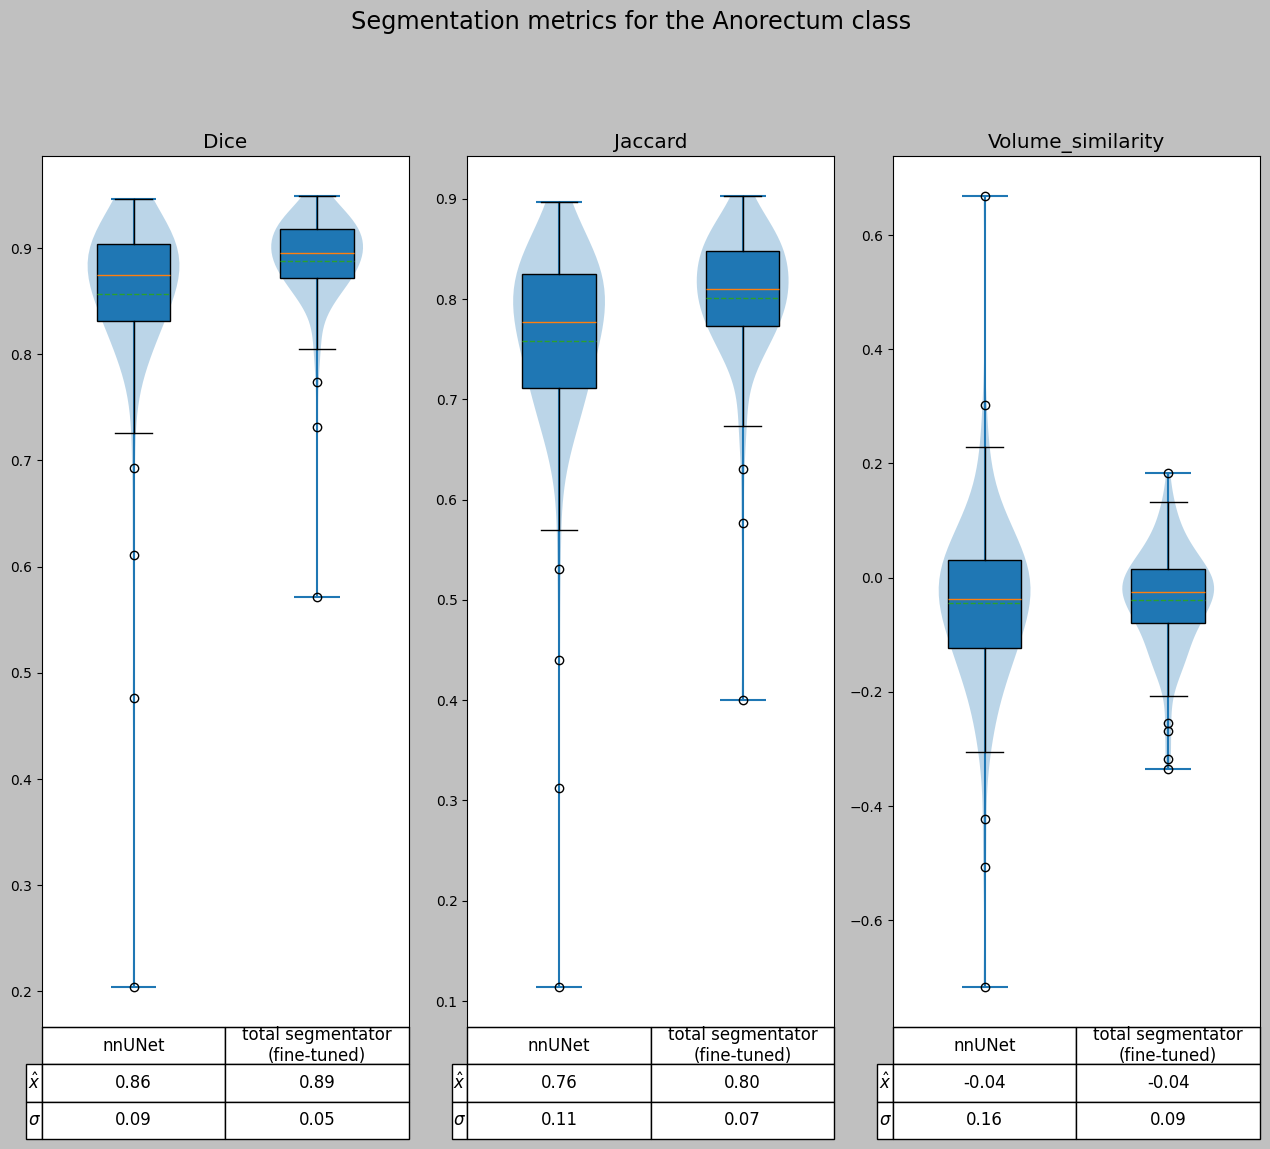

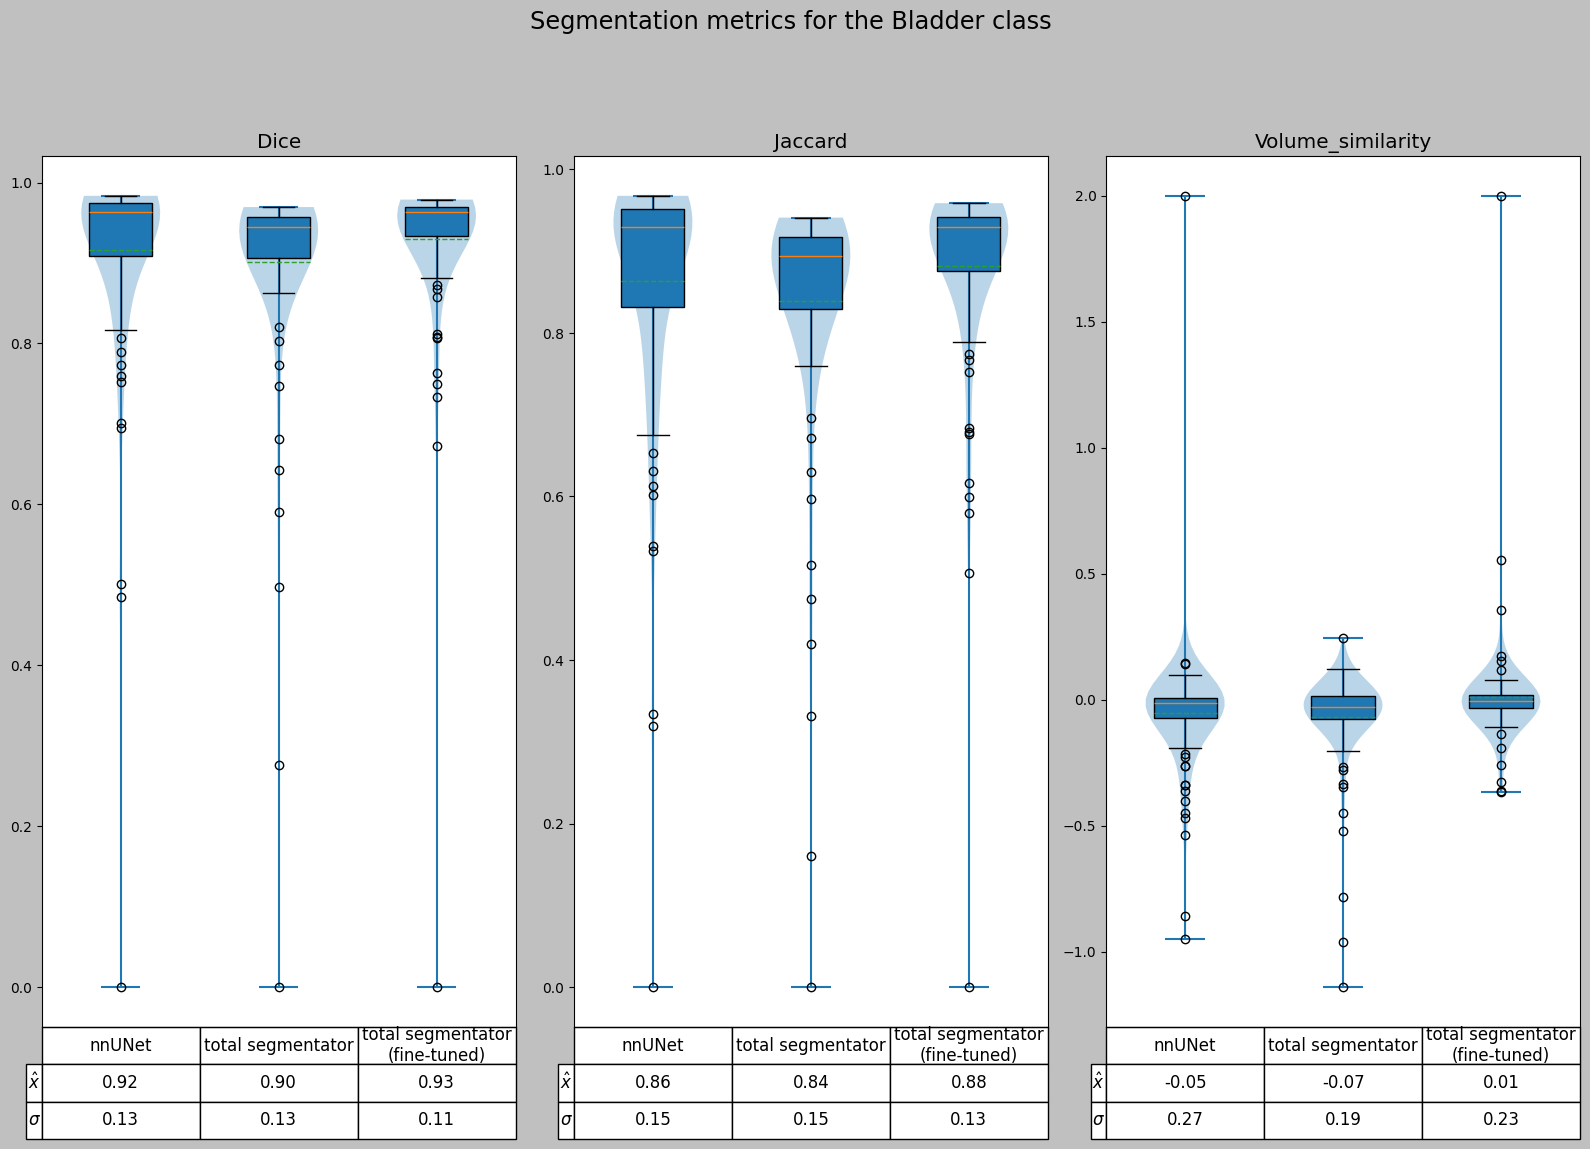

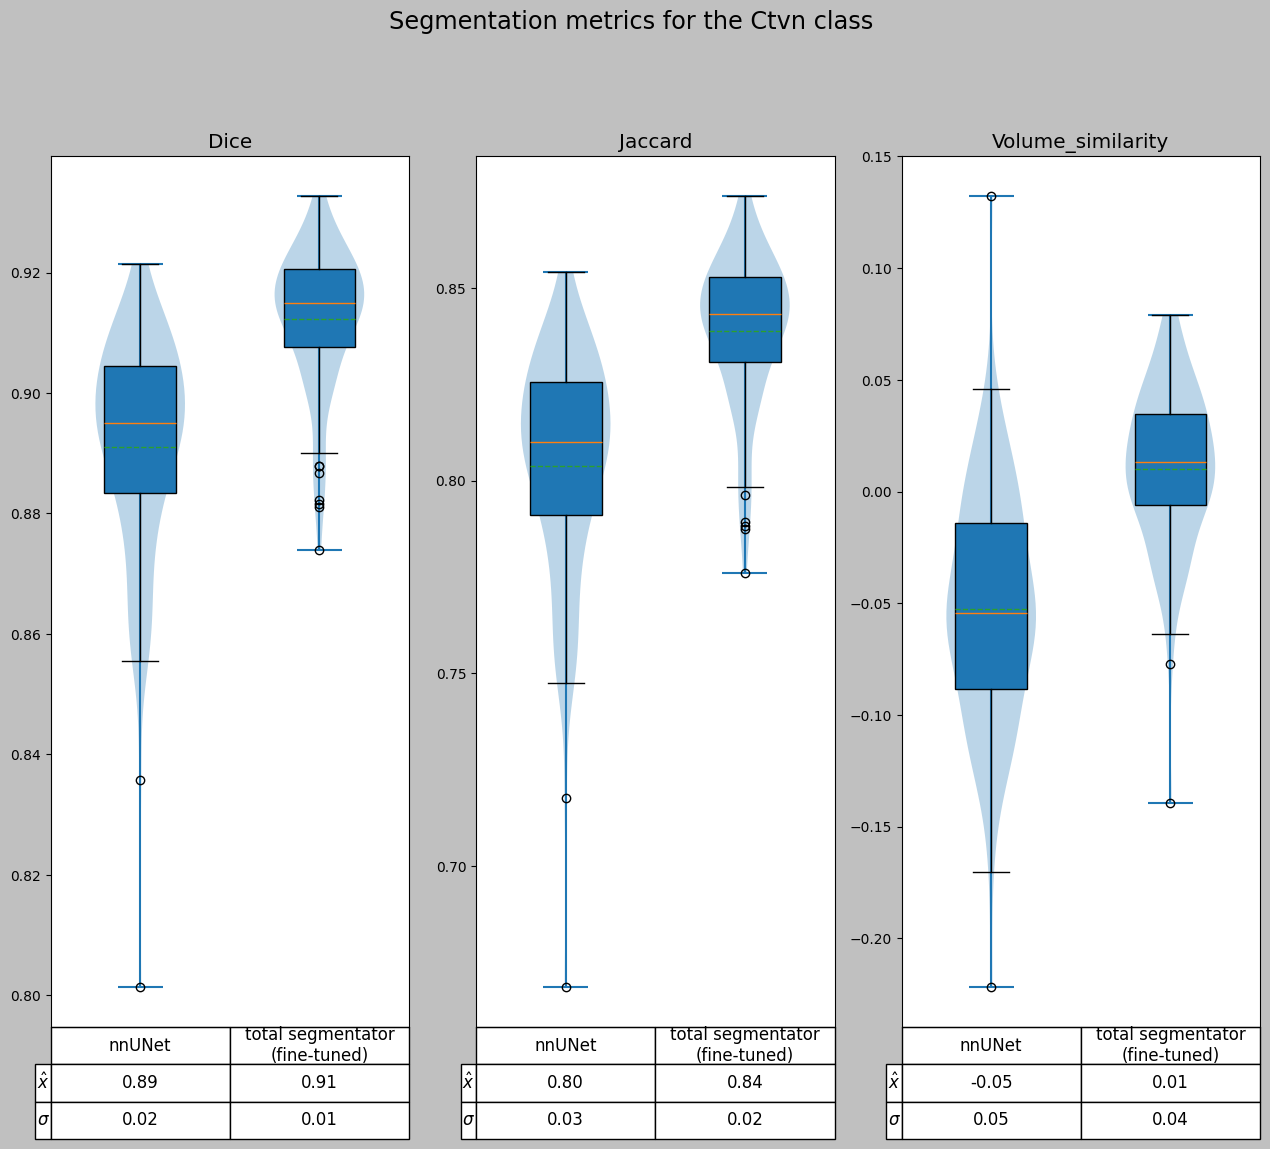

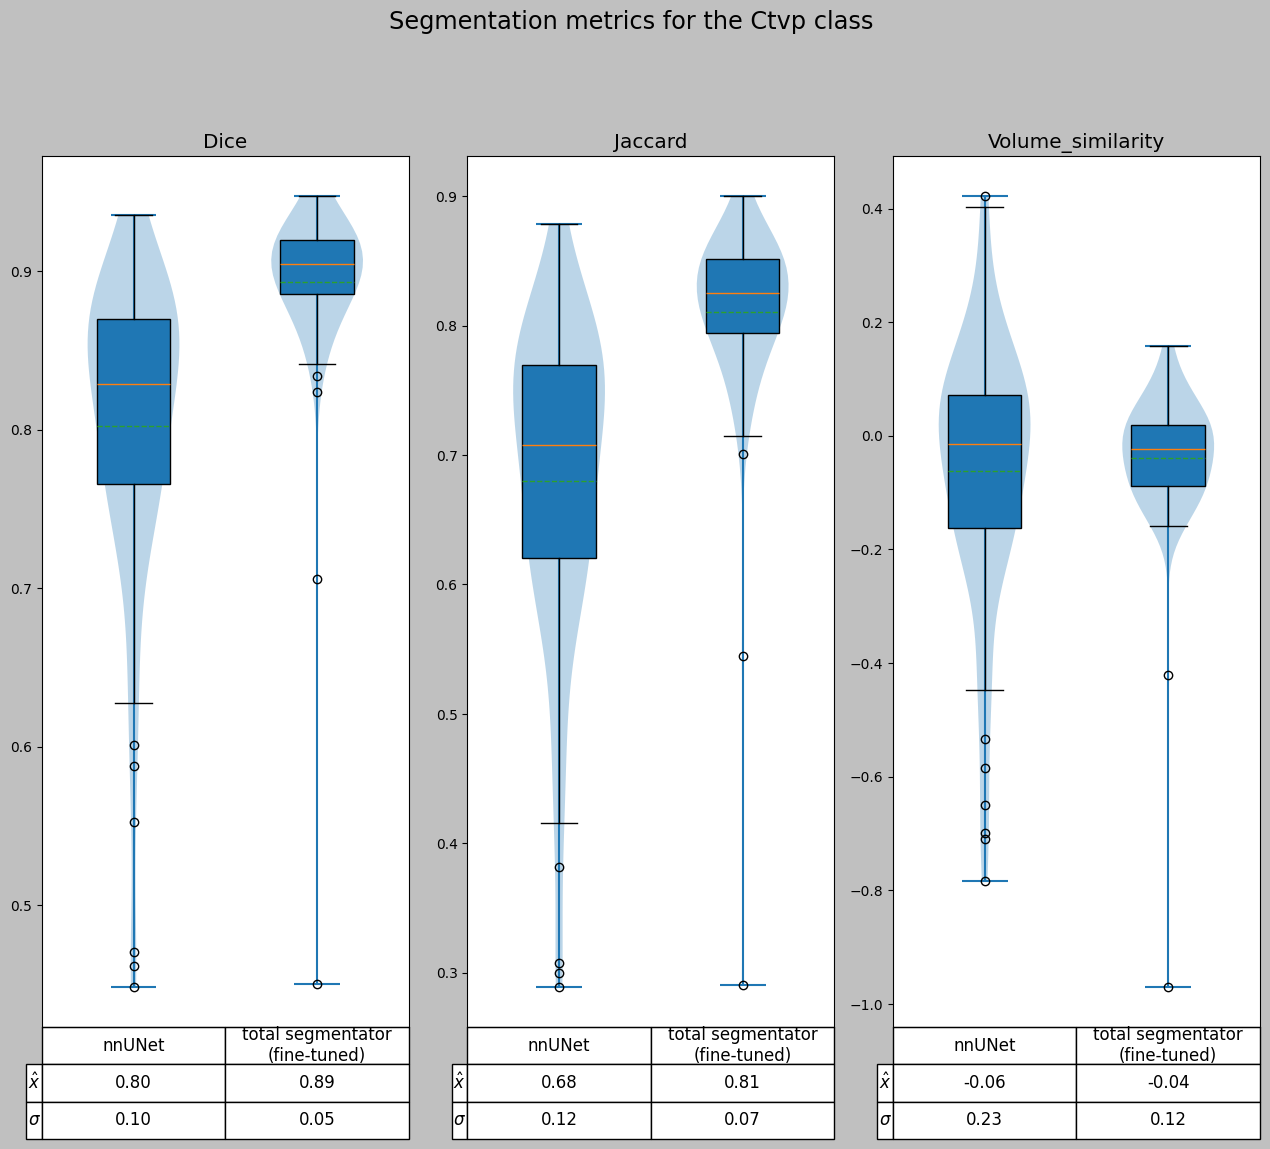

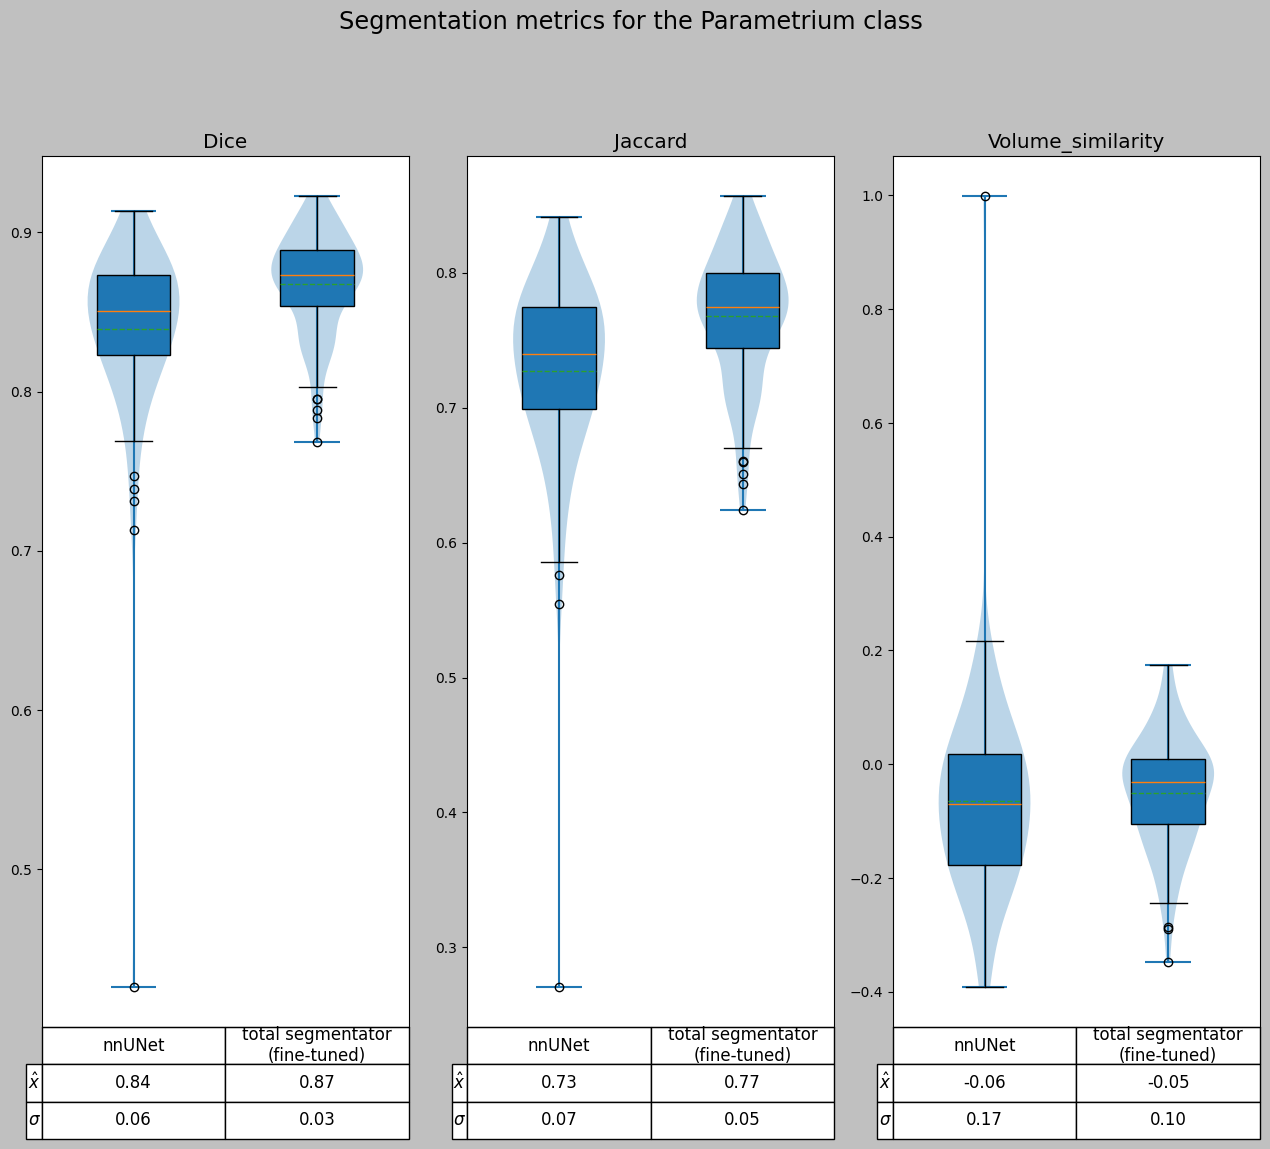

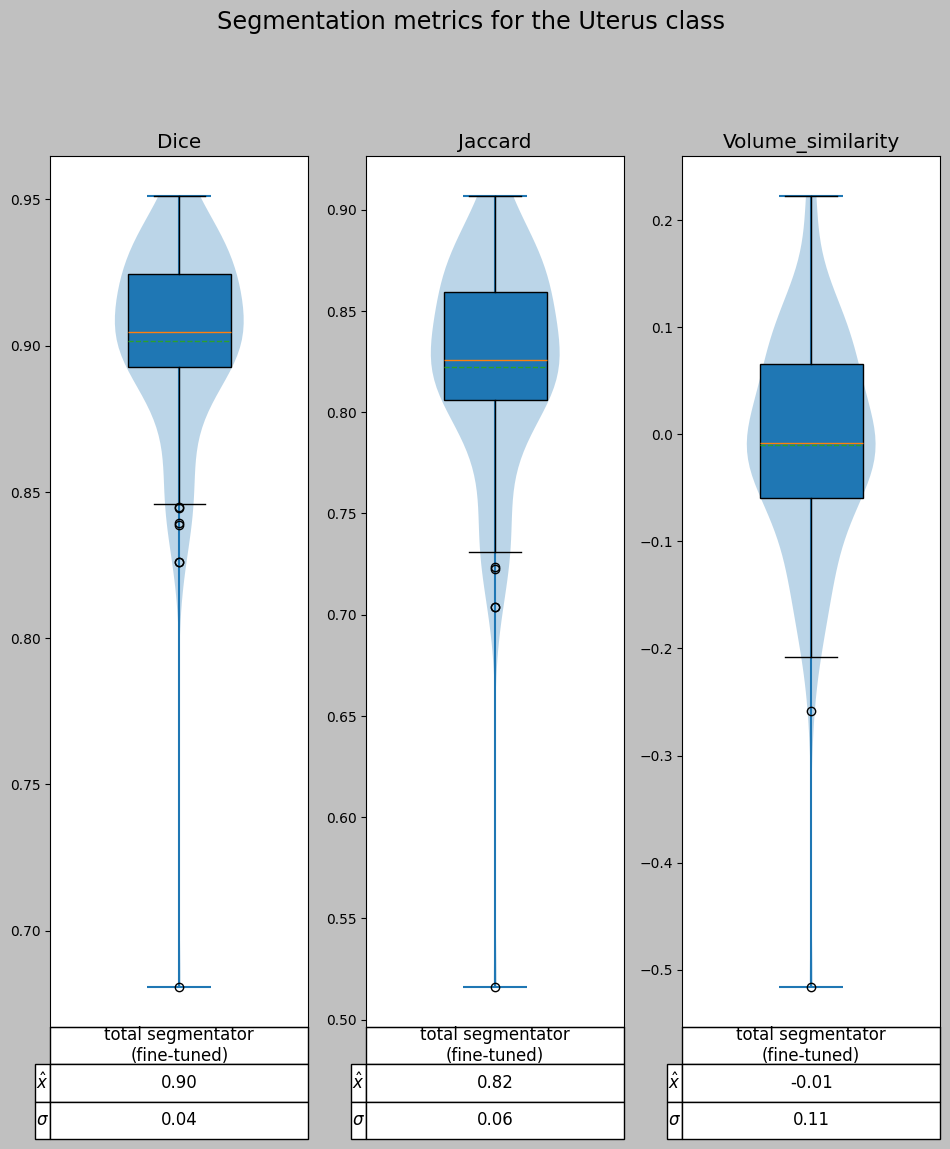

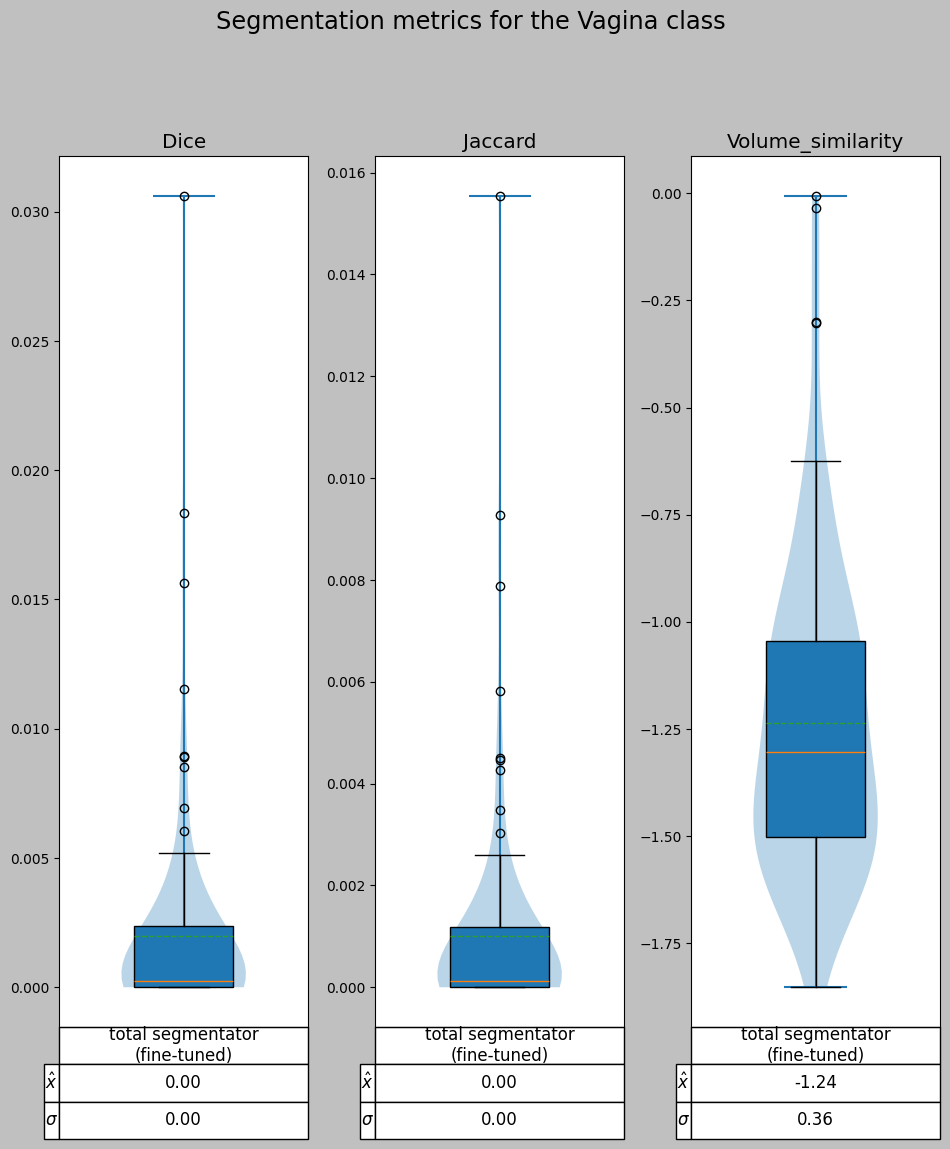

In [6]:
save = True
separate = False
table = True

plot_metrics(anorectum_metrics, 'anorectum', save=save, separate=separate, table=table)
plot_metrics(bladder_metrics, 'bladder', save=save, separate=separate, table=table)
plot_metrics(ctvn_metrics, 'ctvn', save=save, separate=separate, table=table)
plot_metrics(ctvp_metrics, 'ctvp', save=save, separate=separate, table=table)
plot_metrics(parametrium_metrics, 'parametrium', save=save, separate=separate, table=table)
plot_metrics(uterus_metrics, 'uterus', save=save, separate=separate, table=table)
plot_metrics(vagina_metrics, 'vagina', save=save, separate=separate, table=table)

# plot_metrics(anorectum_metrics_ax0, 'anorectum', save=save, separate=separate, table=table, additional_title_context='(Axis 0)')
# plot_metrics(bladder_metrics_ax0, 'bladder', save=save, separate=separate, table=table, additional_title_context='(Axis 0)')
# plot_metrics(ctvn_metrics_ax0, 'ctvn', save=save, separate=separate, table=table, additional_title_context='(Axis 0)')
# plot_metrics(ctvp_metrics_ax0, 'ctvp', save=save, separate=separate, table=table, additional_title_context='(Axis 0)')
# plot_metrics(parametrium_metrics_ax0, 'parametrium', save=save, separate=separate, table=table, additional_title_context='(Axis 0)')

# plot_metrics(anorectum_metrics_ax1, 'anorectum', save=save, separate=separate, table=table, additional_title_context='(Axis 1)')
# plot_metrics(bladder_metrics_ax1, 'bladder', save=save, separate=separate, table=table, additional_title_context='(Axis 1)')
# plot_metrics(ctvn_metrics_ax1, 'ctvn', save=save, separate=separate, table=table, additional_title_context='(Axis 1)')
# plot_metrics(ctvp_metrics_ax1, 'ctvp', save=save, separate=separate, table=table, additional_title_context='(Axis 1)')
# plot_metrics(parametrium_metrics_ax1, 'parametrium', save=save, separate=separate, table=table, additional_title_context='(Axis 1)')

# plot_metrics(anorectum_metrics_ax2, 'anorectum', save=save, separate=separate, table=table, additional_title_context='(Axis 2)')
# plot_metrics(bladder_metrics_ax2, 'bladder', save=save, separate=separate, table=table, additional_title_context='(Axis 2)')
# plot_metrics(ctvn_metrics_ax2, 'ctvn', save=save, separate=separate, table=table, additional_title_context='(Axis 2)')
# plot_metrics(ctvp_metrics_ax2, 'ctvp', save=save, separate=separate, table=table, additional_title_context='(Axis 2)')
# plot_metrics(parametrium_metrics_ax2, 'parametrium', save=save, separate=separate, table=table, additional_title_context='(Axis 2)')

In [ ]:
anorectum_metrics = fetch_metric_for_class(1)
bladder_metrics = fetch_metric_for_class(2)
ctvn_metrics = fetch_metric_for_class(3)
ctvp_metrics = fetch_metric_for_class(4)
parametrium_metrics = fetch_metric_for_class(5)
uterus_metrics = fetch_metric_for_class(6)
vagina_metrics = fetch_metric_for_class(7)

# anorectum_metrics_ax0 = fetch_metric_for_class(1, axis=0)
# bladder_metrics_ax0 = fetch_metric_for_class(2, axis=0)
# ctvn_metrics_ax0 = fetch_metric_for_class(3, axis=0)  
# ctvp_metrics_ax0 = fetch_metric_for_class(4, axis=0)
# parametrium_metrics_ax0 = fetch_metric_for_class(5, axis=0)

# anorectum_metrics_ax1 = fetch_metric_for_class(1, axis=1)
# bladder_metrics_ax1 = fetch_metric_for_class(2, axis=1)
# ctvn_metrics_ax1 = fetch_metric_for_class(3, axis=1)
# ctvp_metrics_ax1 = fetch_metric_for_class(4, axis=1)
# parametrium_metrics_ax1 = fetch_metric_for_class(5, axis=1)

# anorectum_metrics_ax2 = fetch_metric_for_class(1, axis=2)
# bladder_metrics_ax2 = fetch_metric_for_class(2, axis=2)
# ctvn_metrics_ax2 = fetch_metric_for_class(3, axis=2)
# ctvp_metrics_ax2 = fetch_metric_for_class(4, axis=2)
# parametrium_metrics_ax2 = fetch_metric_for_class(5, axis=2)

Calculating metrics for nnUNet: 0it [00:00, ?it/s]

Calculating metrics for nnUNet: 100it [00:25,  4.00it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:23,  4.20it/s]
Calculating metrics for nnUNet: 100it [00:22,  4.47it/s]
Calculating metrics for total segmentator: 100it [00:22,  4.49it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:21,  4.58it/s]
Calculating metrics for nnUNet: 100it [00:22,  4.50it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.50it/s]
Calculating metrics for nnUNet: 100it [00:22,  4.53it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.52it/s]
Calculating metrics for nnUNet: 100it [00:22,  4.51it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.53it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.53it/s]
Calculating metrics for total segmentator (fine-tuned): 100it [00:22,  4.53it/s]
